In [1]:
import os
import sys
import math
import time
import gzip
import random

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",50)

import matplotlib.pyplot as plt
import seaborn as sns
PATH='~/crystallinePolymer/data'

In [2]:
sample_list = pd.read_csv(os.path.join(PATH, 'SampleInfo.csv'), index_col=0, dtype={'CrystTemp': int, 'CrysTime': int, 'Cooling': bool})
sample_list['NucConc'] = sample_list['NucConc'].round(3)

enzyme = pd.read_csv(os.path.join(PATH, 'enzyme','2.csv'), index_col=0)
#enzyme.T

sscurve = pd.read_csv(os.path.join(PATH, 'tensiletest','2','55d','summary.csv'))
sscurve['SampleNo']=sscurve.index+1
sscurve=sscurve.set_index('SampleNo')
#sscurve.T

## 生分解性と降伏応力と関係する構造をRandom Forestで ##  
peakの高さで補正した方を

In [3]:
from sklearn.ensemble import RandomForestRegressor
y_e=enzyme.query('SampleNo>16 & SampleNo<81')["day6"]
y_ss=sscurve.query('SampleNo>16 & SampleNo<81')["Yield stress/MPa"]

waxd=pd.read_csv(PATH+"/corrected_data/waxd_corrected.csv")
waxd['wQ']='w'+waxd["Q"].astype(str)
waxd_wide=waxd.pivot(index='SampleNo',columns='wQ',values='corrected_Intensity')
saxs=pd.read_csv(PATH+"/corrected_data/saxs_corrected.csv")
saxs['sQ']='s'+saxs["Q"].astype(str)
saxs_wide=saxs.pivot(index='SampleNo',columns='sQ',values='corrected_Intensity')
ws_data=pd.merge(waxd_wide,saxs_wide,left_index=True,right_index=True)
ws_data

,w0.013803951,w0.041411851,w0.06901975,w0.096627653,w0.12423556,w0.15184346,w0.17945136,w0.20705926,w0.23466715,w0.26227507,w0.28988296,w0.31749088,w0.34509876,w0.37270665,w0.40031457,w0.42792246,w0.45553038,w0.48313826,w0.51074618,w0.5383541000000001,w0.56596196,w0.59356987,w0.62117779,w0.64878565,w0.67639357,...,s0.53194934,s0.53676337,s0.5415774,s0.54639143,s0.55120546,s0.55601948,s0.56083345,s0.56564748,s0.57046151,s0.57527554,s0.58008957,s0.5849036,s0.58971763,s0.59453166,s0.59934562,s0.60415965,s0.60897368,s0.61378771,s0.61860174,s0.62341577,s0.6282298000000001,s0.63304383,s0.63785779,s0.64267182,s0.64748585
SampleNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.756742,1.563785,1.489895,1.265819,1.140050,1.512363,1.730541,1.834176,1.642493,1.486283,1.571964,1.664080,1.788581,1.579415,1.737071,1.630912,1.813075,1.572893,1.881745,1.512160,1.351116,1.367999,1.768958,1.717685,1.717192
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.119896,0.951442,1.182261,0.656075,0.866913,0.832350,0.926494,1.018940,1.006112,1.025081,0.834238,1.255549,1.079572,0.804743,1.206884,0.847924,1.325331,1.092759,1.447713,1.286225,1.166950,1.361819,1.540004,1.172633,1.052837
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.563054,-0.255249,0.393360,-0.250719,-0.552013,-0.284209,0.124613,0.237064,0.322569,0.030789,0.053197,0.095141,-0.049500,-0.201907,0.274799,0.458809,0.133655,0.539086,0.598287,0.073009,0.317349,0.631000,0.904763,0.300932,-0.046282
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.563486,-3.738417,-3.362272,-3.622064,-3.940415,-3.824060,-3.515826,-3.073305,-3.253658,-3.776513,-3.800889,-3.259750,-3.657419,-3.973151,-3.355918,-3.317664,-3.173160,-2.819690,-3.190651,-3.596102,-3.515332,-2.838322,-2.463791,-3.181125,-3.247541
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.719078,1.482962,1.475575,1.369782,1.354649,1.515151,1.734610,1.899752,1.777160,1.393095,1.631403,2.099241,1.567379,1.750069,2.194692,1.900320,1.910031,1.827088,1.941818,1.856411,1.682685,2.095693,2.290317,2.098984,1.682745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.607213,-5.956299,-5.955859,-6.201891,-5.854720,-6.253971,-6.041136,-5.826173,-6.132209,-6.396935,-6.493184,-6.003259,-5.987103,-6.428065,-6.161246,-5.794482,-5.919016,-5.489507,-5.668442,-6.168502,-6.235857,-5.707148,-5.251950,-5.982786,-6.171265
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.664786,1.095649,0.869651,0.572687,0.426400,0.618281,0.779285,0.960760,0.592576,0.685238,0.681976,0.428599,0.790658,0.291657,0.260561,0.648888,0.758016,1.014670,0.990511,0.765927,0.634665,0.607473,0.549264,0.533187,0.709629
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.392153,0.281389,0.378561,-0.106182,-0.022613,0.135400,-0.106624,0.254268,0.858777,0.711189,0.300761,0.434291,0.253076,0.409476,0.198331,0.053140,0.834631,1.031995,0.791058,0.663571,0.264715,0.608238,0.532211,0.332198,0.473912


In [6]:
ws2e_RF = RandomForestRegressor(max_depth=30, n_estimators=500, random_state=1)
ws2e_RF.fit(ws_data,y_e)

print("生分解性")
enz_importance=pd.DataFrame({'WAXD SAXS position':ws_data.columns, 'importance': ws2e_RF.feature_importances_})
enz_importance.sort_values('importance',ascending=False).head(10)

生分解性


,WAXD SAXS position,importance
97,w10.698062,0.066299
623,w7.3298979000000015,0.063095
96,w10.670454,0.057230
622,w7.302289999999998,0.056976
617,w7.1642504,0.040052
624,w7.3575058,0.035441
98,w10.72567,0.034563
100,w10.780886,0.025804
625,w7.385113700000002,0.024987
618,w7.1918583,0.020608


In [7]:
#importance top5の相関係数
enz_top5=enz_importance.sort_values('importance',ascending=False).head(5)['WAXD SAXS position']
for col in enz_top5:
    cor=ws_data[col].corr(y_e)
    print(str(col)+" : "+str(cor))

qe=[]
for col in enz_top5:
    qe.append(float(col[1:]))


w10.698062 : 0.8580235649276465
w7.3298979000000015 : 0.8345271451450182
w10.670454 : 0.8630752916698317
w7.302289999999998 : 0.8309686163805846
w7.1642504 : 0.7609369469042638


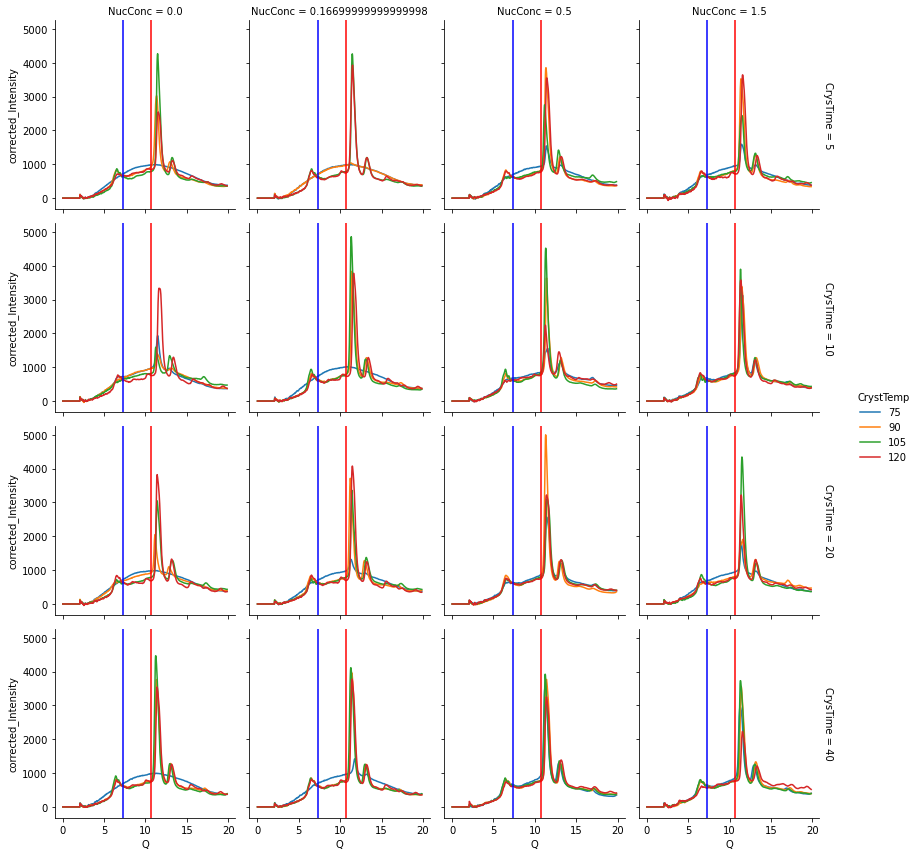

In [9]:
grid = sns.FacetGrid(data=waxd,col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

for row in range(0,4) :
    for col in range(0,4) :
        grid.axes[row,col].axvline(x=qe[0],color="r")
        grid.axes[row,col].axvline(x=qe[1],color="b")
plt.savefig("../fig/RandomForest/Enzyme_importance_saxs.pdf")

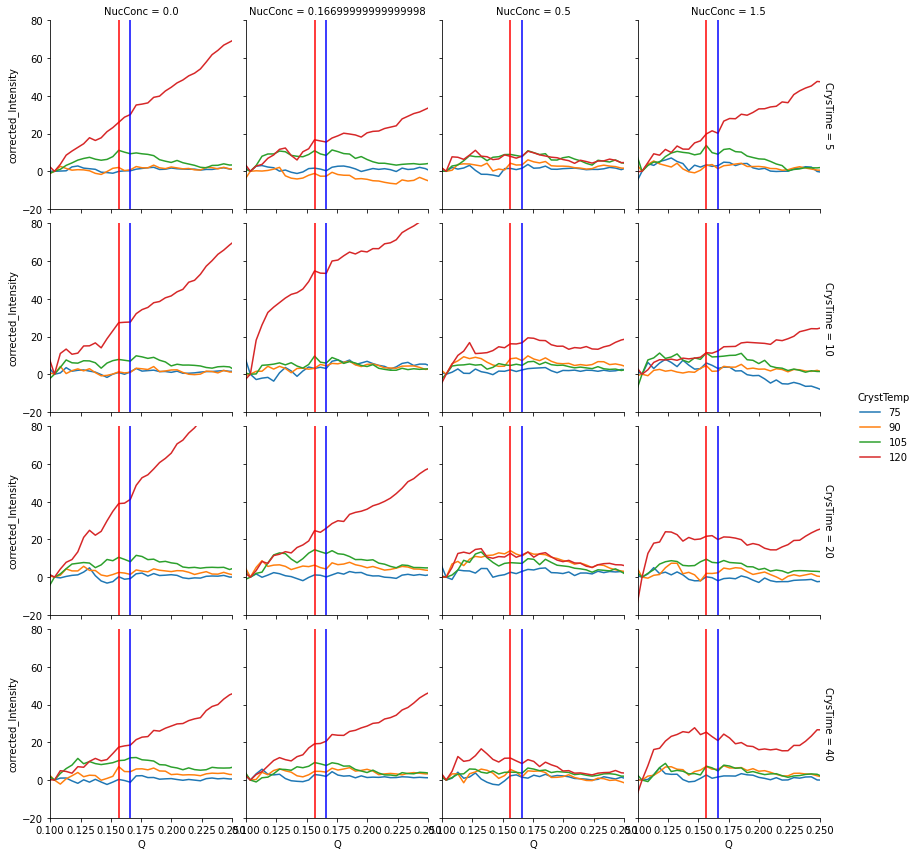

In [31]:
grid = sns.FacetGrid(data=saxs,col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()
grid.set(xlim=(0.1,0.25),ylim=(-20,80))


for row in range(0,4) :
    for col in range(0,4) :
        grid.axes[row,col].axvline(x=qe[0],color="r")
        grid.axes[row,col].axvline(x=qe[1],color="b")


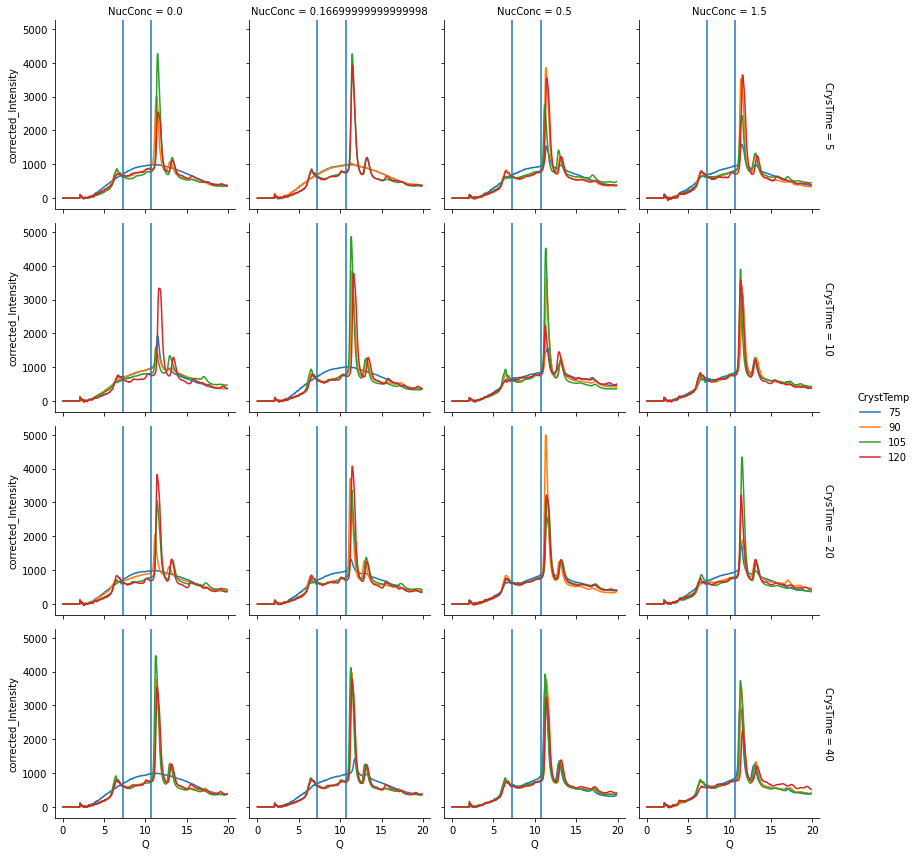

In [32]:
#importance３番目(WAXD:7.2470741)と4番目(WAXD:10.698062)
grid = sns.FacetGrid(data=waxd,col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

for row in range(0,4) :
    for col in range(0,4) :
        grid.axes[row,col].axvline(x=qe[2])
        grid.axes[row,col].axvline(x=qe[3])
plt.savefig("../fig/RandomForest/Enzyme34_importance_waxd.pdf")

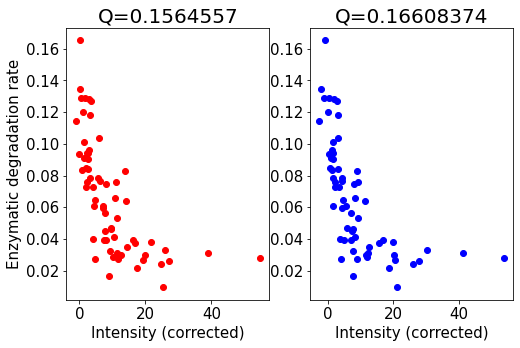

In [36]:
## SAXS Q=0.1564557, 0.16608374　と 生分解性の散布図
fig, axs = plt.subplots(1, 2, figsize=(8,5))
plt.subplots_adjust(wspace=0.2)
imp0=saxs.query("Q=="+str(qe[0])).merge(y_e,left_on="SampleNo",right_index=True).rename(columns={"day6":"enzyme"})
axs[0].scatter(x=imp0.corrected_Intensity,y=imp0.enzyme ,c='r')
axs[0].set_title("Q="+str(qe[0]),fontsize=20)
axs[0].set_xlabel("Intensity (corrected)",fontsize=15)
axs[0].set_ylabel("Enzymatic degradation rate",fontsize=15)
axs[0].tick_params(labelsize=15)

imp1=saxs.query("Q=="+str(qe[1])).merge(y_e,left_on="SampleNo",right_index=True).rename(columns={"day6":"enzyme"})
axs[1].scatter(x=imp1.corrected_Intensity,y=imp1.enzyme, c='b')
axs[1].set_title("Q="+str(qe[1]),fontsize=20)
axs[1].set_xlabel("Intensity (corrected)",fontsize=15)
axs[1].tick_params(labelsize=15)

plt.savefig("../fig/RandomForest/Enzyme_Intensity_point.pdf")

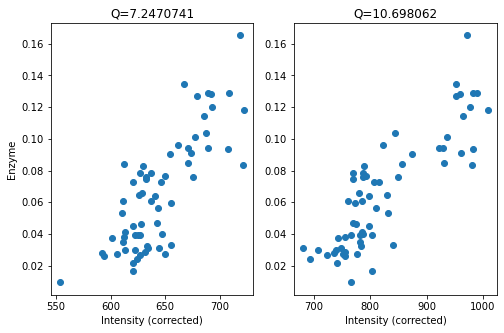

In [34]:
#importance３番目(WAXD:7.2470741)と4番目(WAXD:10.698062)の散布図
fig, axs = plt.subplots(1, 2, figsize=(8,5))
plt.subplots_adjust(wspace=0.2)
imp0=waxd.query("Q=="+str(qe[2])).merge(y_e,left_on="SampleNo",right_index=True).rename(columns={"day6":"enzyme"})
axs[0].scatter(x=imp0.corrected_Intensity,y=imp0.enzyme)
axs[0].set_title("Q="+str(qe[2]))
axs[0].set_xlabel("Intensity (corrected)")
axs[0].set_ylabel("Enzyme")

imp1=waxd.query("Q=="+str(qe[3])).merge(y_e,left_on="SampleNo",right_index=True).rename(columns={"day6":"enzyme"})
axs[1].scatter(x=imp1.corrected_Intensity,y=imp1.enzyme)
axs[1].set_title("Q="+str(qe[3]))
axs[1].set_xlabel("Intensity (corrected)")
plt.savefig("../fig/RandomForest/Enzyme34_Intensity_point.pdf")

In [7]:
ws2ss_RF = RandomForestRegressor(max_depth=30, n_estimators=500, random_state=1)
ws2ss_RF.fit(ws_data,y_ss)

print("降伏応力")
ss_importance=pd.DataFrame({'WAXD SAXS position':ws_data.columns, 'importance': ws2ss_RF.feature_importances_})
ss_importance.sort_values('importance',ascending=False).head(10)

降伏応力


,WAXD SAXS position,importance
190,w13.265596,0.114091
617,w7.1642504,0.095408
103,w10.863709,0.067602
616,w7.1366425000000016,0.046785
189,w13.237988,0.038478
100,w10.780886,0.027698
183,w13.072341,0.017838
101,w10.808494,0.016769
92,w10.560022,0.016508
104,w10.891317,0.015707


In [12]:
#importance top5の相関係数
ss_top5=ss_importance.sort_values('importance',ascending=False).head(5)['WAXD SAXS position']
for col in ss_top5:
    cor=ws_data[col].corr(y_ss)
    print(str(col)+" : "+str(cor))

qs=[]
for col in ss_top5:
    qs.append(float(col[1:]))

w13.265596 : 0.7306589438977039
w7.1642504 : -0.6987395283180523
w10.863709 : -0.7271638794152624
w7.1366425000000016 : -0.636595549354482
w13.237988 : 0.7470084187258554


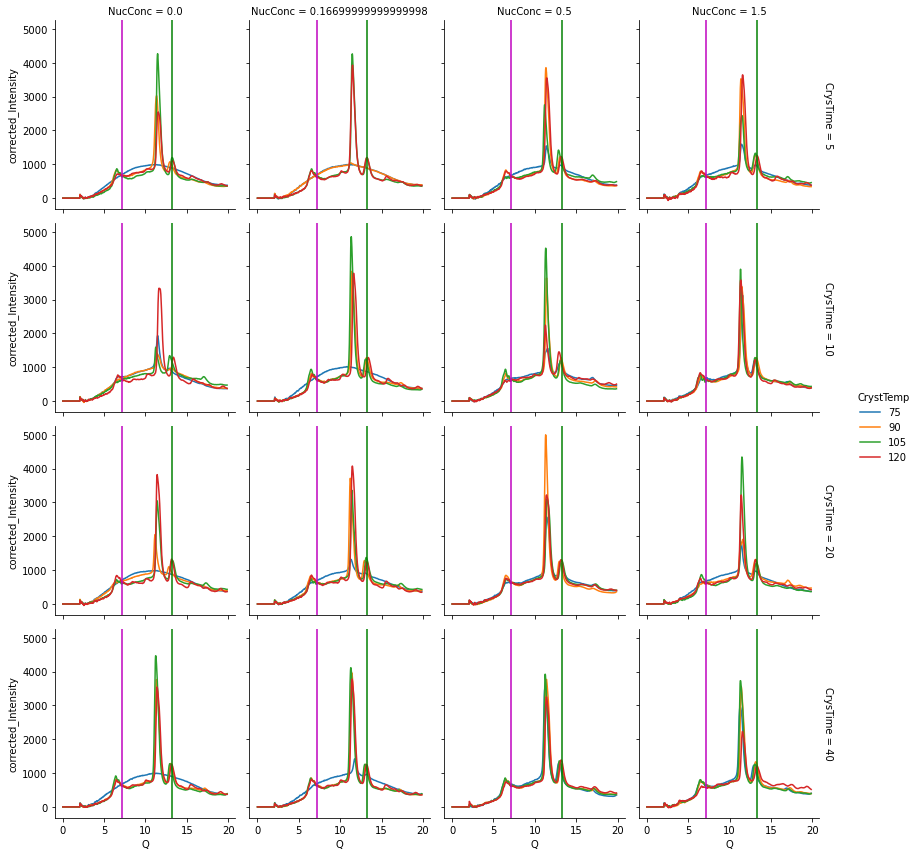

In [10]:
grid = sns.FacetGrid(data=waxd,col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

for row in range(0,4) :
    for col in range(0,4) :
        grid.axes[row,col].axvline(x=qs[0],color="g")
        grid.axes[row,col].axvline(x=qs[1],color="m")
#        grid.axes[row,col].axvline(x=qs[2],color='y')
plt.savefig("../fig/RandomForest/YieldStress_importance_waxd.pdf")

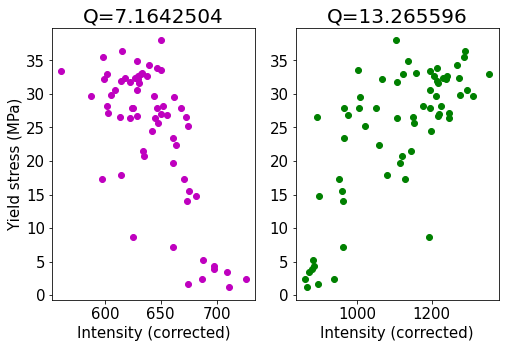

In [13]:
## WAXD Q=13.265596, 7.1642504, 10.863709　と 生分解性の散布図
fig, axs = plt.subplots(1, 2,figsize=(8,5))
#fig, axs = plt.subplots(1, 3,figsize=(12,5))
plt.subplots_adjust(wspace=0.2)
imp0=waxd.query("Q=="+str(qs[0])).merge(y_ss,left_on="SampleNo",right_index=True).rename(columns={"Yield stress/MPa":"Yieldstress"})
axs[1].scatter(x=imp0.corrected_Intensity,y=imp0.Yieldstress, c='g')
axs[1].set_title("Q="+str(qs[0]),fontsize=20)
axs[1].set_xlabel("Intensity (corrected)",fontsize=15)
#axs[1].set_ylabel("Yield stress (MPa)",fontsize=15)
axs[1].tick_params(labelsize=15)


imp1=waxd.query("Q=="+str(qs[1])).merge(y_ss,left_on="SampleNo",right_index=True).rename(columns={"Yield stress/MPa":"Yieldstress"})
axs[0].scatter(x=imp1.corrected_Intensity,y=imp1.Yieldstress, c='m')
axs[0].set_title("Q="+str(qs[1]),fontsize=20)
axs[0].set_xlabel("Intensity (corrected)",fontsize=15)
axs[0].tick_params(labelsize=15)
axs[0].set_ylabel("Yield stress (MPa)",fontsize=15)

"""
imp2=waxd.query("Q=="+str(qs[2])).merge(y_ss,left_on="SampleNo",right_index=True).rename(columns={"Yield stress/MPa":"Yieldstress"})
axs[2].scatter(x=imp2.corrected_Intensity,y=imp2.Yieldstress, c='y')
axs[2].set_title("Q="+str(qs[2]))
axs[2].set_xlabel("Intensity (corrected)")
"""
plt.savefig("../fig/RandomForest/YieldStress_Intensity_point.pdf")